### Chain of Thoughts With RAG

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.
* Decompose question -> subt_steps (reasoning)
* Retrieve docs per step (act)
* Combine context (observe)
* Final answer generation (reflect)

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END

d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ingesting documents and preparing retriever

docs = TextLoader("langchain_notes.txt", encoding='utf-8').load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
embedding = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = FAISS.from_documents(documents=chunks, embedding=embedding).as_retriever()

In [3]:
#base model

from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000250D0A30E10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000250D0B7A750>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
#defining state schema

class CoTState(BaseModel):
    question:str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [5]:
# decomposing question into sub-steps

def plan_steps(state:CoTState)->CoTState:
    prompt = f"Break the given question into 2 - 3 reasoning steps: \n \n question: {state.question} "
    result = model.invoke(prompt).content
    sub_questions = [line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps": sub_questions})

In [6]:
# from langchain_core.prompts import PromptTemplate
# query="In what ways do Chains and Agents complement each other, and how might their interplay evolve as LLMs become more autonomous?"
# prompt = f"Break the given question into 2 - 3 reasoning steps: \n \n question:  {query}"
# test_result = model.invoke(prompt)
# test_result.content



In [7]:
#[line.strip() for line in test_result.content.split("\n\n") if line.strip("**")]

In [8]:
#Retrieving for each step

def retrieve_per_step(state:CoTState)->CoTState:
    all_docs=[]
    for question in state.sub_steps:
        doc = retriever.invoke(question)
        all_docs.extend(doc)

    return state.model_copy(update={"retrieved_docs": all_docs})    


In [12]:
#generate final answer

def generate_answer(state:CoTState)-> CoTState:
    combined_docs = " ".join([doc.page_content for doc in state.retrieved_docs ])
    prompt = """
        answer the following question only based on context information provided.
        question: {state.question} \n \n
        context: {combined_docs}  """
    final_answer = model.invoke(prompt).content.strip()
    return state.model_copy(update={"answer":final_answer})
    

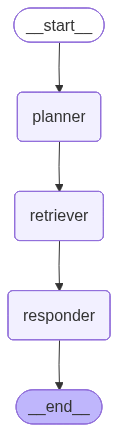

In [13]:
#langgraph graph

graph = StateGraph(CoTState)

graph.add_node("planner", plan_steps)
graph.add_node("retriever", retrieve_per_step)
graph.add_node("responder", generate_answer)

graph.add_edge(START, "planner")
graph.add_edge("planner", "retriever")
graph.add_edge("retriever", "responder")
graph.add_edge("responder", END)

graph_builder = graph.compile()
graph_builder

In [14]:
#invoking graph with a query

if __name__=="__main__":
    query="what is use of integrating langchain with langsmith"
    state=CoTState(question=query)
    final = graph_builder.invoke(state)

    print(f"\n Reasoning Steps:", final['sub_steps'])
    print(f"Final answer:\n", final['answer'])


 Reasoning Steps: ['Here are 3 reasoning steps to break down the question:', '**Step 1: Understanding Langchain and Langsmith**', 'Langchain is an open-source framework for building large language models, and Langsmith is a Python library that provides a set of tools for fine-tuning and deploying language models. To understand the use of integrating Langchain with Langsmith, we need to know the capabilities and strengths of both frameworks.', '**Step 2: Identifying the Benefits of Integration**', "The integration of Langchain with Langsmith could potentially leverage the strengths of both frameworks to create a more robust and efficient language model development pipeline. Langchain's ability to handle complex model architectures and Langsmith's fine-tuning capabilities could be combined to create a more accurate and adaptable language model.", '**Step 3: Potential Use Cases and Applications**', 'Some potential use cases for integrating Langchain with Langsmith could include:', '* Fin